# Quantum Chemistry Tutorial 4 - Geometry optimization

1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
       
February 2024

Dans ce tutoriel, nous allons apprendre à optimiser la structure géométrique des molécules en utilisant 
* RDKit
* xTB et CREST
* GeometriC de PySCF

## Optimisation avec RDKit

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol
import rdkit
from pathlib import Path

rdkit.__version__

'2023.09.5'

#### 2D

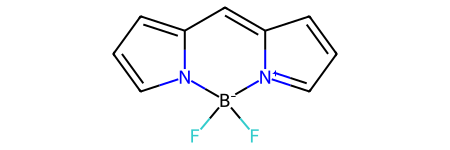

In [2]:
smile = '[B-]1(n2cccc2C=C3[N+]1=CC=C3)(F)F' # BODIPY
smi_key = 'BODIPY'
# Defines a molecule from its SMILES string
mol_rdkit = Chem.MolFromSmiles(smile)
mol_rdkit

#### 3D non optimisée

In [3]:
 # Verify if the "data2402_{smi_key}" subdirectory exist and if not, create it
working_dir = Path(f'./data2402/{smi_key}')
# Create the output directory if it doesn't exist
working_dir.mkdir(parents=True, exist_ok=True)
#Checking
working_dir

PosixPath('data2402/BODIPY')

In [4]:
def view3D(mol, output_file, fmt='mol'):
        """3D vizualisation of mol/xyz file with Py3DMol
        """

        view = py3Dmol.view(width=400, height=400)

        if fmt=='mol':
            view.addModel(Chem.MolToMolBlock(mol), fmt)
            # view.addModel(mol, fmt)
        elif fmt=='xyz':
            view.addModel(mol, fmt)

        view.setStyle({'stick': {}, 'sphere': {'scale': .30}})
        view.zoomTo()
        view.show()
        # view.png(output_file)

In [5]:
# Add explicit Hs
mol_rdkit = Chem.AddHs(mol_rdkit)

# Generates the initial 3D conformation of the molecule
AllChem.EmbedMolecule(mol_rdkit)

# 3D visualization
path_3d_smi = working_dir / f'{smi_key}_3d_smi.png'
view3D(mol_rdkit, path_3d_smi)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### 3D pré-optimisée avec MMFF94

In [6]:
# Optimizes the 3D conformation of the molecule using MMFF - Merck Molecular Force Field
AllChem.MMFFOptimizeMolecule(mol_rdkit, maxIters=200, mmffVariant="MMFF94s")

#Canonicalize the orientation of the conformation
Chem.rdMolTransforms.CanonicalizeMol(mol_rdkit, normalizeCovar=True, ignoreHs=False)

# 3D visualization
path_3d_rdkit = working_dir / f'{smi_key}_3d_rdkit.png'
view3D(mol_rdkit,path_3d_rdkit)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### 3D à nouveau optimisée avec xTB et CREST

##### Installation et configuration de xTB et CREST

* Entrer dans le terminal (dans l'environnment python où on souhaite faire l'installation)

>$ `pip install xtb, crest`
<!-- et 
>$ `whereis xtb`
pour obtenir le chemin des fichiers exécutables. On obtient un output semblable à ceci:
>$ 

* Ajouter le chemin dans `~/.bashrc`. Pour celà, il faut entrer dans 
 export XTBPATH=/home/taamangtchu/mambaforge/envs/qiskit-env/bin/xtb
 
 export PATH=$PATH:/home/taamangtchu/mambaforge/envs/qiskit-env/bin/xtb -->


In [7]:
!xtb --version

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

normal termination of xtb


In [8]:
!crest --version


       |                                            |
       |                 C R E S T                  |
       |                                            |
       |  Conformer-Rotamer Ensemble Sampling Tool  |
       |          based on the GFN methods          |
       |             P.Pracht, S.Grimme             |
       |          Universitaet Bonn, MCTC           |
       Version 2.12,   Thu 19. Mai 16:32:32 CEST 2022
  Using the xTB program. Compatible with xTB version 6.4.0

   Cite work conducted with this code as

   • P.Pracht, F.Bohle, S.Grimme, PCCP, 2020, 22, 7169-7192.
   • S.Grimme, JCTC, 2019, 15, 2847-2862.

   and for works involving QCG as

   • S.Spicher, C.Plett, P.Pracht, A.Hansen, S.Grimme,
     JCTC, 2022, 18 (5), 3174-3189.

   with help from:
   C.Bannwarth, F.Bohle, S.Ehlert, S.Grimme,
   C.Plett, P.Pracht, S.Spicher

   This program is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; without even the implied warranty of
   M

##### Processus d'optimisation semi-empirique

In [9]:
import xtb, crest
import subprocess as sp # pour exécuter les processus externes (ici xtb et crest)

# Setting various paths for xtb files
path_xtb_xyz = working_dir / f'{smi_key}_opt.xyz'
path_xtb_log = working_dir / f'{smi_key}_opt.log'
path_xtb_csv = working_dir / f'{smi_key}_xtb.csv'
path_xtb_png = working_dir / f'{smi_key}_opt.png'


In [10]:
if not path_xtb_xyz.exists():
    print(f'path_xtb_xyz does not exist and will be created')

    # Convert RDKit molecule to XYZ format
    mol_rdkit_xyz = Chem.MolToXYZBlock(mol_rdkit)
    with open("mol_rdkit.xyz", "w") as f:
        f.write(mol_rdkit_xyz)

    # Geometry pre-optimization using GFn-XTB with different parameters
    sp.run(["xtb","mol_rdkit.xyz", "--gfn2", "--opt", "vtight", "--parallel 1"], 
            stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)

    # Best conformation search
    sp.run(['crest', 'xtbopt.xyz', '-gff', '-mquick', '--noreftopo'], stdout=sp.DEVNULL, stderr=sp.DEVNULL)

    # xtb geometry optimization of the crest best conformation
    xtb_process = sp.run(["xtb", 'crest_best.xyz', "--gfn2", "--opt", "vtight", "--parallel 1"],
                        stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)

    # Store the xtbopt.xyz file in path_xtb_xyz
    sp.run(['cp', 'xtbopt.xyz', path_xtb_xyz], stdout=sp.PIPE, stderr=sp.DEVNULL)

    with open(path_xtb_log, "w") as fl:
        fl.write(xtb_process.stdout)


path_xtb_xyz does not exist and will be created


In [11]:
print(path_xtb_log.read_text())

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; w

##### Gap HOMO-LUMO et energie totale

Nous allons rechercher les valeurs du gap HOMO-LUMO et de l'énergie totale dans le fichier de sortie (path_xtb_log) en utilisant le module *re*.

In [12]:
import re

#---------------------------------------------------------------------
# Extract the total energy ang Homo=lumo gap from the xtb output file
#---------------------------------------------------------------------
# Find HOMO-LUMO GAP value
match_gap = re.search(r"HOMO-LUMO GAP\s+(\d+\.\d+)\s+eV", path_xtb_log.read_text())
if match_gap:
    HL_gap_xtb = float(match_gap.group(1))

# Find TOTAL ENERGY value
match_energy = re.search(r"TOTAL ENERGY\s+(-?\d+\.\d+)", path_xtb_log.read_text())
if match_energy:
    tot_energy_xtb = float(match_energy.group(1))

In [13]:
import pandas as pd

# Create the xtb results dataframe
df_xtb = pd.DataFrame({'xtb calc':[HL_gap_xtb, tot_energy_xtb]}, index=["HOMO-LUMO GAP (eV)","TOTAL ENERGY (a.u.)"])
# Save the xtb results dataframe to a file
with open(path_xtb_csv, "w") as f:
    f.write(f"\n\nxtb calculations of {smi_key}  \n")
    df_xtb.to_csv(f)
    
df_xtb

/tmp/ipykernel_19497/1072878687.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,xtb calc
HOMO-LUMO GAP (eV),1.790733
TOTAL ENERGY (a.u.),-39.530635


In [14]:
sp.run(['rm', 'bondlengths', 'charges', 'coord', 'coord.original', 'cregen_0.tmp', 'cregen_1.tmp', 
        'cre_members', 'crest_best.xyz', 'crest_conformers.xyz', 'crest.energies', 'crest_rotamers.xyz', 
        'gfnff_charges', 'gfnff_topo', '.history.xyz', 'struc.xyz', 'wbo','xtbopt.xyz', 'xtbopt.log', '.xtboptok', 
        'xtbrestart', 'xtbtopo.mol', 'xtblast.xyz', 'gfnff_adjacency'], stdout=sp.DEVNULL, stderr=sp.DEVNULL)

CompletedProcess(args=['rm', 'bondlengths', 'charges', 'coord', 'coord.original', 'cregen_0.tmp', 'cregen_1.tmp', 'cre_members', 'crest_best.xyz', 'crest_conformers.xyz', 'crest.energies', 'crest_rotamers.xyz', 'gfnff_charges', 'gfnff_topo', '.history.xyz', 'struc.xyz', 'wbo', 'xtbopt.xyz', 'xtbopt.log', '.xtboptok', 'xtbrestart', 'xtbtopo.mol', 'xtblast.xyz', 'gfnff_adjacency'], returncode=1)

In [15]:
# Read the XYZ file
with open(path_xtb_xyz, "r") as f:
    mol_xtb_xyz = f.read()

lines =mol_xtb_xyz.strip().split('\n')
mol_xtb_xyz = '\n'.join(lines[:1] + [''] + lines[2:])

view3D(mol_xtb_xyz,path_xtb_png,fmt='xyz')


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Calcul du champ moyen HF

A l'issue de ce calcul, nous avons l'énergie de référence SCF. 

#### Choix de l'ensemble de base 

Nous allons d'abord effectuer le choix de l'ensemble de base nous donnant le meilleur compromis précision de la valeur de l'énergie et temps de calculs.

In [16]:
import time, datetime
from pyscf import gto, scf

In [17]:

# Convert mol_rdkit object to Pyscf Mol objects
mol_xyz = '\n'.join(mol_xtb_xyz.strip().split('\n')[2:])

mol_pyscf = gto.Mole(
    atom=mol_xyz,
    charge=0,
    spin = 0,
    symmetry = True,
    unit = 'Angstrom')

In [18]:
basis_sets = [
    "6-31G",            # Double zeta with 6 Gaussian primitives
    "6-31G*",           # Double zeta with 6 Gaussian primitives
    "6-31G(d,p)",       # Double zeta with 6 Gaussian primitives with polarization functions and diffuse functions
    "6-311G(d,p)",      # Triple zeta with polarization functions
    "def2-SVP",         # Double zeta with polarization functions
    "def2-SVPD",        # Double zeta with polarization functions and diffuse functions
    "def2-TZVP",        # Triple zeta with polarization functions
    "def2-TZVPD",       # Triple zeta with polarization functions and diffuse functions
    "def2-TZVPP"        # Triple zeta with polarization functions and diffuse functions
]

In [19]:
# To write output results of mf.analysis on a file
# path_HF_basis_log = working_dir / f'{smi_key}_HF_basis.log'
# mol_pyscf.output = path_HF_basis_log

mf_energies = list()
mf_times = list()
nb_prim = list()

# Perform a Mean-Field calculation for each basis set
for bs in basis_sets:

    # Measure execution time
    start = time.time()
    mol_pyscf.basis = bs
    mol_pyscf.build()

    mf = scf.RHF(mol_pyscf) # Create a PySCF HF mean-field object
    mf.x2c().density_fit() # To speed up calculations
    mf.kernel()
    end = time.time()

    nb_prim.append(mol_pyscf.npgto_nr())
    mf_energies.append(mf.e_tot)
    mf_times.append(end-start)

/home/taamangtchu/mambaforge/envs/qiskit-env/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -677.273999282048


converged SCF energy = -677.50709391343
converged SCF energy = -677.520673412817
converged SCF energy = -677.663366418188
converged SCF energy = -676.998751541871
converged SCF energy = -677.022823679044
converged SCF energy = -677.768708498232
converged SCF energy = -677.770133852405
converged SCF energy = -677.771265071204


In [20]:
# Create the results dataframe

df_HF = pd.DataFrame({"Basis":basis_sets, 
                      'Nb of GTO primitives':nb_prim, 
                      'Total energy (a.u.)':mf_energies,
                      "Time (s)":mf_times})

df_HF


,Basis,Nb of GTO primitives,Total energy (a.u.),Time (s)
0,6-31G,336,-677.273999,3.170364
1,6-31G*,406,-677.507094,9.458549
2,"6-31G(d,p)",427,-677.520673,13.992951
3,"6-311G(d,p)",490,-677.663366,96.098695
4,def2-SVP,385,-676.998752,12.743461
5,def2-SVPD,496,-677.022824,211.366726
6,def2-TZVP,700,-677.768708,574.495410
7,def2-TZVPD,811,-677.770134,1407.062665
8,def2-TZVPP,756,-677.771265,636.774390


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Basis</th>
      <th>Nb of GTO primitives</th>
      <th>Total energy</th>
      <th>Time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>6-31G</td>
      <td>336</td>
      <td>-677.623496</td>
      <td>3.669760</td>
    </tr>
    <tr>
      <th>1</th>
      <td>6-31G*</td>
      <td>406</td>
      <td>-677.856129</td>
      <td>5.084911</td>
    </tr>
    <tr>
      <th>2</th>
      <td>6-31G(d,p)</td>
      <td>427</td>
      <td>-677.869629</td>
      <td>5.943991</td>
    </tr>
    <tr>
      <th>3</th>
      <td>6-311G(d,p)</td>
      <td>490</td>
      <td>-678.016787</td>
      <td>9.655276</td>
    </tr>
    <tr>
      <th>4</th>
      <td>def2-SVP</td>
      <td>385</td>
      <td>-677.344944</td>
      <td>5.601832</td>
    </tr>
    <tr>
      <th>5</th>
      <td>def2-SVPD</td>
      <td>496</td>
      <td>-677.368600</td>
      <td>12.596472</td>
    </tr>
    <tr>
      <th>6</th>
      <td>def2-TZVP</td>
      <td>700</td>
      <td>-678.119895</td>
      <td>37.465839</td>
    </tr>
    <tr>
      <th>7</th>
      <td>def2-TZVPD</td>
      <td>811</td>
      <td>-678.121356</td>
      <td>49.101455</td>
    </tr>
    <tr>
      <th>8</th>
      <td>def2-TZVPP</td>
      <td>756</td>
      <td>-678.122451</td>
      <td>38.197197</td>
    </tr>
  </tbody>
</table>
</div>

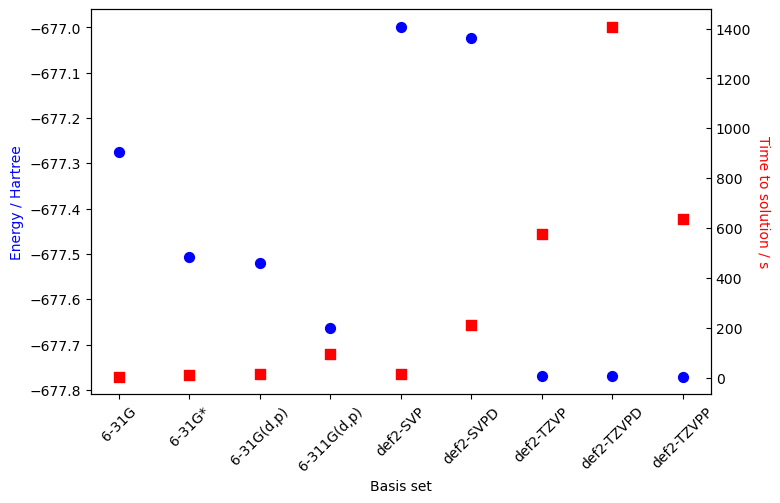

In [21]:
import matplotlib.pyplot as plt

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

# Plot the energies.
ax.set_xticks(range(len(basis_sets)), basis_sets, rotation=45)
ax.set_xlabel("Basis set")
ax.set_ylabel("Energy / Hartree", color="b")
ax.scatter(range(len(basis_sets)), mf_energies, marker="o", s=50, color="b")

# Plot the time to solution
ax_time = ax.twinx()
ax_time.scatter(range(len(basis_sets)), mf_times, marker="s", s=50, color="r")
ax_time.set_ylabel("Time to solution / s", color="r", rotation=270, va="bottom")

# Show the graph
plt.tick_params(axis="both", direction="in")
plt.show()

Il apparait que nous avons le choix entre 6-311(d,p) et def2-TZVP. 

In [22]:
# Setting path for HF results
path_results = working_dir / f'Results_{smi_key}.csv'
path_HF_chk = working_dir / f'{smi_key}_HF.chk'
path_HF_log = working_dir / f'{smi_key}_HF.log'

# To write output results of mf.analysis on a file
mol_pyscf.output = path_HF_log
mol_pyscf.basis = "def2-TZVP"  # Triple zeta with polarization functions

#===============================
# MEAN FIELD SCF CALCULATIONS
#===============================
mf = scf.RHF(mol_pyscf) # Create a PySCF HF mean-field object
mf.x2c().density_fit()   # To speed up calculations
mf.init_guess = '1e' # The one-electron guess, also known as the core guess
mf.verbose = 4
mf.direct_scf = False
# if phase == 'sol':
#     mf = mf.ddCOSMO() # COSMOS Solvation method
#     mf.with_solvent.eps = 2.3741   # Toluene


if path_HF_chk.exists():
    path_HF_status = f'{path_HF_chk} exist'
    start = time.time()

    # Load the SCF results from the checkpoint file
    mf.__dict__.update(chkfile.load(path_HF_chk, 'scf'))
    dm = mf.make_rdm1()
    mf.kernel(dm)

    elapsed_HF = str(datetime.timedelta(seconds = time.time() - start))
else:
    path_HF_status = f'{path_HF_chk} does not exist'
    start = time.time()

    # Save the SCF results to a checkpoint file
    mf.chkfile = path_HF_chk
    mf.kernel()
    if(not mf.converged):
        mf = mf.newton()
        mf.kernel()

    elapsed_HF = str(datetime.timedelta(seconds = time.time()- start))




******** <class 'pyscf.df.df_jk.DFsfX2C1eRHF'> ********
method = DFsfX2C1eRHF
initial guess = 1e
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = False
chkfile to save SCF result = data2402/BODIPY/BODIPY_HF.chk
max_memory 4000 MB (current use 227 MB)
Set gradient conv threshold to 3.16228e-05
Initial guess from hcore.
  HOMO = -23.3150983019013  LUMO = -23.2817804059443
init E= -459.501854624301
  HOMO = -0.519695657729482  LUMO = -0.479299980006065
cycle= 1 E= -328.284716008806  delta_E=  131  |g|= 24.4  |ddm|= 1.09e+03
  HOMO = -5.96580796697772  LUMO = -5.92189384802358
cycle= 2 E= -35.7869012922519  delta_E=  292  |g|= 39.1  |ddm|= 1.06e+03
  HOMO = -2.27654667291253  LUMO = -2.15994578780768
cycle= 3 E= -543.441715432871  delta_E= -508  |g|= 19.9  |ddm|=  393
  HOMO = -0.188887179885543  LUMO = -0.177429398516578
cycle= 4 E= -597.69654

In [33]:
import numpy as np

from pyscf.data import nist 
from pyscf import gto, scf, dft, tddft, ao2mo, fci, solvent
from pyscf.geomopt.geometric_solver import optimize
from pyscf.lib import chkfile
from pyscf.tools import cubegen

au2ev = nist.HARTREE2EV

In [24]:
# !pip install pyscf[geomopt]

### DFT

Nous allons optimiser à noveau S0 en utilisant *Geometry optimization* de PySCF.

In [28]:
#=====================================
# DFT CALCULATIONS
#=====================================

# Setting path for DFT results, chkfile and analyze object
path_results = working_dir / f'Results_{smi_key}.csv'
path_DFT_chk = working_dir / f'{smi_key}_DFT.chk'
path_DFT_log = working_dir / f'{smi_key}_DFT.log'
path_xyz_opt1 = working_dir / f'{smi_key}_opt1.xyz'
path_xyz_opt2 = working_dir / f'{smi_key}_opt2.xyz'

# T write output results of mdft.analysis on a file
mol_pyscf.output = path_DFT_log

# S0 optimization

# Singlets GS DFT calculations
mdft = dft.RKS(mol_pyscf) # Create a PySCF DFT mean-field object
mdft.density_fit(auxbasis='def2-universal-jkfit') # To speed up calculations
mdft.xc = 'B3LYP'
mdft.max_cycle = 512
mdft.grids.level = 3  # Level of grid accuracy (higher is more accurate)
mdft.conv_tol = 1E-7
mdft.grids.becke_scheme=dft.gen_grid.original_becke # Use the Becke 'Good' grid

# Run analyze function in callback
def cb(envs):
    mdft = envs['g_scanner'].base
    mdft.analyze(verbose=4)

# if phase == 'sol':
# # Set up the COSMO solvation model
#     mdft = mdft.run().ddCOSMO()
#     mdft.with_solvent.eps = 2.3741   # Toluene


if path_DFT_chk.exists():
    path_DFT_status = f'{path_DFT_chk} exist'
    start = time.time()

    # Load the DFT results from the checkpoint file
    mdft.__dict__.update(chkfile.load(path_DFT_chk, 'scf'))
    mdft.kernel()

    elapsed_DFT = str(datetime.timedelta(seconds = time.time() - start))
else:
    path_DFT_status = f'{path_DFT_chk} does not exist'
    start = time.time()

    # Save the DFT results to a checkpoint file
    mdft.chkfile = path_DFT_chk

    # Add callback to geometry optimizer
    mdft = mdft.nuc_grad_method().as_scanner().optimizer()
    mdft.callback = cb
    mdft.kernel()

    if(not mdft.converged):
        mdft = mdft.newton(mdft)
        mdft.kernel()

    elapsed_DFT = str(datetime.timedelta(seconds = time.time()- start))



converged SCF energy = -681.651566507696


In [29]:
# Dipole moment
dip_mt2 = mdft.dip_moment(mdft.mol, mdft.make_rdm1())

# # Analyze the given DFT object
# mdft.analyze()

# Index of HOMO and LUMO
homo_idx = np.where(mdft.mo_occ > 0)[0][-1]
lumo_idx = np.where(mdft.mo_occ == 0)[0][0]

# Output cube files for active orbitals that can read by Vesta or XCryDen
for i in [homo_idx, lumo_idx]:
    cubegen.orbital(
        mol_pyscf,
        working_dir / f'{smi_key}_DFT_{i+1}.cube',
        mdft.mo_coeff[:, i])


Dipole moment(X, Y, Z, Debye):  0.00047,  4.26358,  0.00162


In [30]:
# Create the DFT results dataframe
list_results_DFT = [mdft.e_tot,
                    mdft.energy_elec()[0],
                    mdft.energy_nuc(),
                    mdft.mo_energy[homo_idx],
                    mdft.mo_energy[lumo_idx],
                    mdft.mo_energy[homo_idx] - mdft.mo_energy[lumo_idx]]
dict_results_DFT = {'a.u.': list_results_DFT,
                'eV': [x * au2ev for x in list_results_DFT]}
df_DFT = pd.DataFrame(dict_results_DFT,
                    index = ['Total energy',
                                'Electronic energy',
                                'Nuclear repulsion energy',
                                'MO energy of HOMO',
                                'MO energy of LUMO',
                                'HOMO-LUMO gap'])

# Save the DFT results dataframe to a file
with open(path_results, "a") as f:
    f.write(f"\n\nDFT calculations of {smi_key} obtained in; \
        {elapsed_DFT}s ; as {path_DFT_status} \n")
    f.write(f"Dipole moments ; {dip_mt2[0], dip_mt2[1], dip_mt2[2]}\n")

    df_DFT.to_csv(f)

### TDDFT-TDA calculations

In [32]:
#==================================
# TDDFT-TDA CALCULATIONS
#==================================

# Singlets ES TDDFT calculations with Tamm-Dancoff-approximation
#==================================
mftda = tddft.TDA(mdft)
mftda.nstates = 2
# if phase == 'sol':
#     mftda = mftda.ddCOSMO()
#     mftda.with_solvent.eps = 2.3741   # Toluene
#     mftda.with_solvent.equilibrum_solvation = True


# Setting path for singlets TDDFT-TDA chkfile
path_TDA_chk = working_dir / f'{smi_key}_TDA.chk'

if path_TDA_chk.exists():
    path_TDA_status = f'{path_TDA_chk} exist'
    start = time.time()

    # Load the TDA singlet results from the checkpoint file
    mftda.__dict__.update(chkfile.load(path_TDA_chk, 'tddft'))
    E_TDA = mftda.kernel()

    elapsed_TDA = str(datetime.timedelta(
        seconds = time.time() - start))
else:
    path_TDA_status = f'{path_TDA_chk} does not exist'
    start = time.time()

    # Save the TDA singlet results to a checkpoint file
    mftda.chkfile = path_TDA_chk
    E_TDA = mftda.kernel()
    #if(not mftda.converged):
        #mftda = tddft.TDA.newton(mftda)
        #E_TDA = mftda.kernel()

    elapsed_TDA = str(datetime.timedelta(
        seconds = time.time()- start))

# Singlet excitation energies
ee_singlets = mftda.e

# Singlet oscillators strength
OS_singlets = mftda.oscillator_strength(gauge='length')


# Triplets ES TDDFT calculations with Tamm-Dancoff-approximation
#==================================
mftda.singlet = False

# Setting path for triplets TDDFT-TDA chkfile
path_TDA3_chk = working_dir / f'{smi_key}_TDA3.chk'

if path_TDA3_chk.exists():
    path_TDA3_status = f'{path_TDA3_chk} exist'
    start = time.time()

    # Load the TDA triplet results from the checkpoint file
    mftda.__dict__.update(chkfile.load(path_TDA3_chk, 'tddft'))
    E_TDA3 = mftda.kernel()

    elapsed_TDA3 = str(datetime.timedelta(seconds = time.time() - start))
else:
    path_TDA3_status = f'{path_TDA3_chk} don\'t exist'
    start = time.time()

    # Save the TDA results to a checkpoint file
    mftda.chkfile = path_TDA3_chk
    E_TDA3 = mftda.kernel()

    elapsed_TDA3 = str(datetime.timedelta(seconds = time.time() - start))

# Triplet excitation energies
ee_triplets = mftda.e


Excited State energies (eV)
[3.45335396 3.95348167]
Excited State energies (eV)
[1.72243384 2.88992563]


NameError: name 'nist' is not defined

In [ ]:
# Sought results
#==================================
#
# fluorescence energy
f_energy = min(ee_singlets)

# Singlet-Tiplet gap
gap_ST = min(ee_singlets) - min(ee_triplets)

# Oscillator strength
OStr = OS_singlets[0]

# Lifetime calculation in au
c = nist.LIGHT_SPEED # in au
time_au = 2.4188843265857E-17 # in au

tau_au = c**3 / (2 * (f_energy)**2 * OStr)
tau = tau_au * time_au

# Multi-Objective function
mobj = OStr - gap_ST * au2ev - np.abs(f_energy * au2ev - 3.2)

#=====================================
# DataFrame and saving in file
#=====================================

# Create the results dataframe
list_results_TDA = [f_energy, gap_ST, OStr, tau, mobj]
dict_results_TDA = {'a.u.': list_results_TDA,
            'eV/ns': [f_energy * au2ev,
                    gap_ST * au2ev,
                    OStr,
                    tau * 1E+9,
                    mobj]}

df_TDA = pd.DataFrame(dict_results_TDA,
                    index = ['Fluorescence energy',
                                'Singlet-Triplet gap',
                                'Oscillator strength',
                                'Lifetime',
                                'Multi-Obj'])

# Save the TDDFT-TDA results dataframe to a file
with open(path_results, "a") as f:
    f.write(f"\n\nTDDFT-TDA calculations of {smi_key} obtained in; \
            {elapsed_TDA}s ; as {path_TDA_status}\n \
            {elapsed_TDA3}s ; as {path_TDA3_status}\n")
    df_TDA.to_csv(f)
